# 1. Importing modules and functions

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [3]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'KlekotaRoth',
 'SubstructureCount',
 'Substructure']

In [4]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

# 2.Data entry and curation work set

In [5]:
uploaded_file_ws="datasets/HDAC6_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  3083 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [6]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [7]:
len(y_tr)

3083

# 3.Standardization SDF file for work set

In [8]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  3083 molecules


In [9]:
records_ws = []
for i in range(len(moldf_ws)):
    record = Chem.MolToSmiles(moldf_ws[i])
    records_ws.append(record)

In [10]:
df = pd.DataFrame(records_ws, columns=["Smiles"])
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

# 4.Data entry and curation test set

In [11]:
uploaded_file_ts="datasets/HDAC6_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  771 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [12]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [13]:
len(y_ts)

771

# 5.Standardization SDF file for test set

In [14]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  771 molecules


In [15]:
records_ts = []
for i in range(len(moldf_ts)):
    record = Chem.MolToSmiles(moldf_ts[i])
    records_ts.append(record)

In [16]:
df_ts = pd.DataFrame(records_ts, columns=["Smiles"])
df_ts.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

# 6.Descriptor calculation for work set

In [16]:
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

## KlekotaRoth FPs

In [ ]:
from padelpy import padeldescriptor

fingerprint = 'KlekotaRoth'

fingerprint_output_file = ''.join([fingerprint,'.csv']) #KlekotaRoth.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi', 
                d_file=fingerprint_output_file, #'KlekotaRoth.csv'
                #descriptortypes='KlekotaRoth.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [2]:
descriptors_KlekotaRoth = pd.read_csv('KlekotaRoth.csv')

In [3]:
descriptors_KlekotaRoth

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,AUTOGEN_molecule_ws_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,AUTOGEN_molecule_ws_3079,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3079,AUTOGEN_molecule_ws_3080,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3080,AUTOGEN_molecule_ws_3081,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3081,AUTOGEN_molecule_ws_3082,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
x_tr = descriptors_KlekotaRoth.drop('Name', axis=1)

In [20]:
x_tr = np.array(x_tr, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [23]:
savetxt('Models/Padels/x_tr_KlekotaRoth.csv', x_tr, delimiter=',')

In [21]:
x_tr.shape

(3083, 4860)

# 7.Descriptor calculation for test set

In [179]:
from padelpy import padeldescriptor

fingerprint = 'KlekotaRoth'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) #KlekotaRoth.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ts.smi', 
                d_file=fingerprint_output_file, #'KlekotaRoth.csv'
                #descriptortypes='KlekotaRoth.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [22]:
descriptors_KlekotaRoth_ts = pd.read_csv('KlekotaRoth_ts.csv')

In [23]:
x_ts = descriptors_KlekotaRoth_ts.drop('Name', axis=1)

In [24]:
x_ts.shape

(771, 4860)

 # GradientBoostingRegressor model building and validation

In [28]:
seed = 42

In [29]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [30]:
param_grid = {'learning_rate': [0.02,0.05],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4, 10]
                 }

In [31]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [32]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05], 'max_depth': [4, 10],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.9, 0.5, 0.1]},
             verbose=1)

In [33]:
best_GBR = m.best_estimator_

In [34]:
m.best_params_

{'learning_rate': 0.02,
 'max_depth': 10,
 'n_estimators': 1000,
 'subsample': 0.5}

In [35]:
y_pred_ws_GBR = best_GBR.predict(x_tr)

In [36]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.94

In [37]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.46

In [38]:
y_pred_CV_GBR = cross_val_predict(best_GBR, x_tr, y_tr, cv=cv)

In [39]:
y_pred_CV_GBR

array([4.94909972, 5.09662772, 4.96424541, ..., 7.4859912 , 6.86014927,
       7.43366292])

In [40]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.66

In [41]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.69

# 9. Prediction for test set's molecules

In [52]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)
len(y_ts)

771

In [53]:
y_pred_GBR = best_GBR.predict(x_ts)

In [54]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.69

In [55]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.67

# save the model to disk

In [46]:
pickle.dump(best_GBR, open('Models/Padels/HDAC6_GBR_KlekotaRoth.pkl', 'wb'))

# load the model from disk

In [111]:
best_GBR = pickle.load(open('Models/Padels/HDAC6_GBR_KlekotaRoth.pkl', 'rb'))

# 10. Y-randomization GradientBoostingRegressor model

In [47]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 241.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 429.5min finished


True score =  0.66 
Y-randomization =  -0.21 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [33]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [34]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.872983,5.099020,3.872983,2.236068,5.385165,2.000000,3.605551,4.358899,3.162278,6.082763,...,2.828427,3.000000,2.645751,2.236068,2.236068,3.000000,2.645751,4.898980,1.732051,5.000000
2,6.000000,5.385165,4.582576,2.645751,6.082763,5.656854,5.291502,5.567764,6.782330,6.244998,...,3.872983,4.242640,3.316625,2.645751,2.236068,4.898980,2.828427,4.898980,3.000000,5.099020
3,6.164414,5.385165,4.690416,2.645751,6.403124,5.916080,5.385165,5.567764,7.141428,6.324555,...,4.795832,4.582576,3.872983,2.828427,2.236068,5.000000,3.162278,5.000000,3.000000,5.099020
4,6.324555,5.385165,4.795832,2.645751,6.403124,6.000000,5.477226,5.656854,7.211102,6.324555,...,4.795832,4.898980,4.472136,3.000000,2.645751,5.000000,3.316625,5.000000,3.162278,5.099020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,13.190906,12.124355,13.453624,13.341664,13.152946,12.727922,12.649111,13.304134,13.379088,12.845233,...,12.767145,12.961481,12.569805,13.000000,13.266500,13.076696,12.449900,13.674794,12.409674,13.266500
3079,13.190906,12.206555,13.453624,13.341664,13.152946,12.727922,12.649111,13.304134,13.453624,12.845233,...,12.806249,12.961481,12.609520,13.000000,13.266500,13.076696,12.489996,13.674794,12.449900,13.266500
3080,13.190906,12.206555,13.453624,13.341664,13.228757,12.727922,12.649111,13.304134,13.490738,12.845233,...,12.845233,12.961481,12.961481,13.000000,13.341664,13.076696,12.649111,13.674794,12.449900,13.266500
3081,13.190906,12.409674,13.490738,13.341664,13.453624,12.767145,12.727922,13.416408,13.564660,12.845233,...,12.884099,12.961481,13.038404,13.114877,13.379088,13.076696,12.727922,13.711309,12.489996,13.304134


In [35]:
similarity= neighbors_k

In [36]:
Dmean=np.mean(similarity[1,:])

In [37]:
round(Dmean, 2)

2.73

In [38]:
std=np.std(similarity[1,:])

In [39]:
round(std, 2)

1.24

In [40]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.34


In [41]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [42]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,2.449490,3.000000,3.605551,6.557439,5.196152,1.000000,2.645751,2.645751,2.645751,3.464102,...,2.449490,1.732051,3.464102,2.000000,1.732051,3.741657,2.828427,2.828427,3.162278,2.236068
1,2.828427,3.162278,4.000000,7.071068,5.291503,3.000000,3.000000,2.645751,2.645751,3.872983,...,2.645751,2.645751,4.000000,2.000000,1.732051,4.000000,4.123106,3.316625,3.605551,2.449490
2,3.000000,4.472136,4.582576,7.141428,5.477226,6.557439,3.000000,3.464102,3.316625,4.000000,...,3.000000,2.828427,4.242641,2.645751,1.732051,4.123106,4.242641,3.605551,3.605551,2.449490
3,3.605551,6.082763,4.898979,7.348469,5.477226,6.855655,3.162278,3.605551,4.472136,4.242641,...,3.000000,3.000000,4.358899,2.828427,2.000000,4.472136,4.242641,3.872983,3.741657,2.645751
4,4.242641,6.164414,5.000000,7.416198,5.567764,6.928203,3.316625,3.605551,4.690416,5.830952,...,3.162278,3.000000,4.472136,3.000000,2.236068,4.472136,4.242641,3.872983,4.123106,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,12.845233,12.000000,12.884099,12.529964,12.727922,13.190906,12.922848,12.124356,13.379088,13.000000,...,13.453624,11.916375,13.527749,12.727922,13.190906,11.832160,13.228757,13.266499,12.649111,12.409674
3079,12.884099,12.124356,12.922848,12.529964,12.767145,13.266499,13.000000,12.124356,13.379088,13.000000,...,13.490738,12.083046,13.564660,12.845233,13.190906,11.874342,13.228757,13.304135,12.688578,12.449900
3080,12.884099,12.206556,12.922848,12.609520,12.767145,13.379088,13.038405,12.165525,13.379088,13.000000,...,13.490738,12.083046,13.638182,12.845233,13.266499,11.958261,13.228757,13.304135,12.727922,12.489996
3081,12.884099,12.369317,12.961481,12.609520,12.767145,13.379088,13.038405,12.328828,13.416408,13.000000,...,13.490738,12.124356,13.674794,13.114877,13.304135,11.958261,13.228757,13.304135,12.727922,12.569805


In [43]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.449 3.    3.606 6.557 5.196 1.    2.646 2.646 2.646 3.464 3.317 2.449
 5.568 2.    2.646 2.646 2.449 5.099 3.606 3.317 4.123 2.828 5.477 2.
 6.245 4.    2.236 5.568 3.162 3.873 4.123 7.071 3.873 3.    2.236 1.732
 4.359 2.646 2.    4.583 5.    3.    3.464 4.69  3.606 2.828 3.464 2.449
 2.    1.    3.606 2.646 4.899 4.    3.742 1.732 2.646 2.646 5.657 3.
 2.828 2.646 3.606 2.646 3.742 4.123 3.162 2.646 1.732 2.646 2.449 1.
 2.449 4.899 2.    1.414 3.    2.646 6.164 3.    1.    3.317 5.    1.732
 4.69  2.646 1.414 1.414 4.583 1.414 3.    2.449 3.162 2.    2.828 6.403
 5.196 3.464 2.236 3.873 2.449 5.831 2.    2.646 4.243 4.123 2.    2.828
 2.646 3.162 2.449 2.646 3.162 3.    3.873 3.    3.464 2.    2.236 2.449
 3.    1.    3.162 3.162 3.317 2.646 3.    2.828 3.162 3.742 2.646 1.414
 2.449 1.732 6.403 2.449 2.449 3.606 2.    1.414 3.162 2.    3.317 0.
 4.243 2.236 1.732 1.732 3.742 1.    2.646 0.    2.449 4.359 4.359 2.236
 1.732 1.732 4.    1.732 3.464 2.449 3.162 0.    2.    1.732 3.

In [44]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True False False False  True  True  True  True False  True  True
 False  True  True  True  True False False  True False  True False  True
 False False  True False  True False False False False  True  True  True
 False  True  True False False  True False False False  True False  True
  True  True False  True False False False  True  True  True False  True
  True  True False  True False False  True  True  True  True  True  True
  True False  True  True  True  True False  True  True  True False  True
 False  True  True  True False  True  True  True  True  True  True False
 False False  True False  True False  True  True False False  True  True
  True  True  True  True  True  True False  True False  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True False  True  True False  True  True  True  True  True  True
 False  True  True  True False  True  True  True  True False False  True
  True  True False  True False  True  True  True  T

In [45]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.74


In [48]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   1   5   6   7   8  10  11  13  14  15  16  19  21  23  26  28  33
  34  35  37  38  41  45  47  48  49  51  55  56  57  59  60  61  63  66
  67  68  69  70  71  72  74  75  76  77  79  80  81  83  85  86  87  89
  90  91  92  93  94  98 100 102 103 106 107 108 109 110 111 112 113 115
 117 118 119 120 121 122 123 124 125 126 127 128 130 131 132 133 135 136
 138 139 140 141 142 143 145 146 147 149 150 151 152 155 156 157 159 161
 162 163 164 165 168 169 170 171 172 173 174 175 176 180 181 183 184 185
 187 189 190 191 192 193 195 196 197 198 199 200 202 203 204 205 206 207
 208 209 210 211 212 214 216 217 219 220 222 223 224 225 226 228 229 230
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 251 252 253 254 255 256 257 259 261 262 263 264 265 266 268 270 271 273
 274 275 277 278 279 280 281 284 285 286 288 289 290 291 293 294 295 297
 298 299 300 302 305 306 308 309 310 311 312 313 314 315 316 317 318 320
 321 324 32

In [49]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [56]:
y_pred_GBR_ad=list(y_pred_GBR)

In [57]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [58]:
len(y_pred_GBR_ad)

572

In [59]:
y_ts_ad=list(y_ts)

In [60]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [61]:
len(y_ts_ad)

572

In [62]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.73

In [63]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.64

# SVM model building and validation

In [64]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [26]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [66]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [67]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [68]:
svm.best_params_
best_svm = svm.best_estimator_

In [69]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [70]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [71]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.91

In [72]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.49

In [73]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [74]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.65

In [75]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.69

# 9. Prediction for test set's molecules

In [76]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [77]:
y_pred_svm = best_svm.predict(x_ts)

In [78]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.7

In [79]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.67

save the model to disk

In [80]:
pickle.dump(best_svm, open('Models/Padels/HDAC6_SVM_KlekotaRoth.pkl', 'wb'))

load the model from disk

In [93]:
best_svm = pickle.load(open('Models/Padels/HDAC6_SVM_KlekotaRoth.pkl', 'rb'))

# 10. Y-randomization SVM model

In [81]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 31.9min


True score =  0.653 
Y-randomization =  -0.26 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 50.5min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [82]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [83]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.872983,5.099020,3.872983,2.236068,5.385165,2.000000,3.605551,4.358899,3.162278,6.082763,...,2.828427,3.000000,2.645751,2.236068,2.236068,3.000000,2.645751,4.898980,1.732051,5.000000
2,6.000000,5.385165,4.582576,2.645751,6.082763,5.656854,5.291502,5.567764,6.782330,6.244998,...,3.872983,4.242640,3.316625,2.645751,2.236068,4.898980,2.828427,4.898980,3.000000,5.099020
3,6.164414,5.385165,4.690416,2.645751,6.403124,5.916080,5.385165,5.567764,7.141428,6.324555,...,4.795832,4.582576,3.872983,2.828427,2.236068,5.000000,3.162278,5.000000,3.000000,5.099020
4,6.324555,5.385165,4.795832,2.645751,6.403124,6.000000,5.477226,5.656854,7.211102,6.324555,...,4.795832,4.898980,4.472136,3.000000,2.645751,5.000000,3.316625,5.000000,3.162278,5.099020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,13.190906,12.124355,13.453624,13.341664,13.152946,12.727922,12.649111,13.304134,13.379088,12.845233,...,12.767145,12.961481,12.569805,13.000000,13.266500,13.076696,12.449900,13.674794,12.409674,13.266500
3079,13.190906,12.206555,13.453624,13.341664,13.152946,12.727922,12.649111,13.304134,13.453624,12.845233,...,12.806249,12.961481,12.609520,13.000000,13.266500,13.076696,12.489996,13.674794,12.449900,13.266500
3080,13.190906,12.206555,13.453624,13.341664,13.228757,12.727922,12.649111,13.304134,13.490738,12.845233,...,12.845233,12.961481,12.961481,13.000000,13.341664,13.076696,12.649111,13.674794,12.449900,13.266500
3081,13.190906,12.409674,13.490738,13.341664,13.453624,12.767145,12.727922,13.416408,13.564660,12.845233,...,12.884099,12.961481,13.038404,13.114877,13.379088,13.076696,12.727922,13.711309,12.489996,13.304134


In [84]:
similarity= neighbors_k

In [85]:
Dmean=np.mean(similarity[1,:])

In [86]:
round(Dmean, 2)

2.73

In [87]:
std=np.std(similarity[1,:])

In [88]:
round(std, 2)

1.24

In [89]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.34


In [90]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [91]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,2.449490,3.000000,3.605551,6.557438,5.196152,1.000000,2.645751,2.645751,2.645751,3.464102,...,2.449490,1.732051,3.464102,2.000000,1.732051,3.741657,2.828427,2.828427,3.162278,2.236068
1,2.828427,3.162278,4.000000,7.071068,5.291502,3.000000,3.000000,2.645751,2.645751,3.872983,...,2.645751,2.645751,4.000000,2.000000,1.732051,4.000000,4.123106,3.316625,3.605551,2.449490
2,3.000000,4.472136,4.582576,7.141428,5.477226,6.557438,3.000000,3.464102,3.316625,4.000000,...,3.000000,2.828427,4.242640,2.645751,1.732051,4.123106,4.242640,3.605551,3.605551,2.449490
3,3.605551,6.082763,4.898980,7.348469,5.477226,6.855655,3.162278,3.605551,4.472136,4.242640,...,3.000000,3.000000,4.358899,2.828427,2.000000,4.472136,4.242640,3.872983,3.741657,2.645751
4,4.242640,6.164414,5.000000,7.416198,5.567764,6.928203,3.316625,3.605551,4.690416,5.830952,...,3.162278,3.000000,4.472136,3.000000,2.236068,4.472136,4.242640,3.872983,4.123106,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,12.845233,12.000000,12.884099,12.529964,12.727922,13.190906,12.922848,12.124355,13.379088,13.000000,...,13.453624,11.916375,13.527749,12.727922,13.190906,11.832160,13.228757,13.266500,12.649111,12.409674
3079,12.884099,12.124355,12.922848,12.529964,12.767145,13.266500,13.000000,12.124355,13.379088,13.000000,...,13.490738,12.083046,13.564660,12.845233,13.190906,11.874342,13.228757,13.304134,12.688578,12.449900
3080,12.884099,12.206555,12.922848,12.609520,12.767145,13.379088,13.038404,12.165525,13.379088,13.000000,...,13.490738,12.083046,13.638182,12.845233,13.266500,11.958261,13.228757,13.304134,12.727922,12.489996
3081,12.884099,12.369317,12.961481,12.609520,12.767145,13.379088,13.038404,12.328828,13.416408,13.000000,...,13.490738,12.124355,13.674794,13.114877,13.304134,11.958261,13.228757,13.304134,12.727922,12.569805


In [92]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.449 3.    3.606 6.557 5.196 1.    2.646 2.646 2.646 3.464 3.317 2.449
 5.568 2.    2.646 2.646 2.449 5.099 3.606 3.317 4.123 2.828 5.477 2.
 6.245 4.    2.236 5.568 3.162 3.873 4.123 7.071 3.873 3.    2.236 1.732
 4.359 2.646 2.    4.583 5.    3.    3.464 4.69  3.606 2.828 3.464 2.449
 2.    1.    3.606 2.646 4.899 4.    3.742 1.732 2.646 2.646 5.657 3.
 2.828 2.646 3.606 2.646 3.742 4.123 3.162 2.646 1.732 2.646 2.449 1.
 2.449 4.899 2.    1.414 3.    2.646 6.164 3.    1.    3.317 5.    1.732
 4.69  2.646 1.414 1.414 4.583 1.414 3.    2.449 3.162 2.    2.828 6.403
 5.196 3.464 2.236 3.873 2.449 5.831 2.    2.646 4.243 4.123 2.    2.828
 2.646 3.162 2.449 2.646 3.162 3.    3.873 3.    3.464 2.    2.236 2.449
 3.    1.    3.162 3.162 3.317 2.646 3.    2.828 3.162 3.742 2.646 1.414
 2.449 1.732 6.403 2.449 2.449 3.606 2.    1.414 3.162 2.    3.317 0.
 4.243 2.236 1.732 1.732 3.742 1.    2.646 0.    2.449 4.359 4.359 2.236
 1.732 1.732 4.    1.732 3.464 2.449 3.162 0.    2.    1.732 3.

In [93]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True False False False  True  True  True  True False  True  True
 False  True  True  True  True False False  True False  True False  True
 False False  True False  True False False False False  True  True  True
 False  True  True False False  True False False False  True False  True
  True  True False  True False False False  True  True  True False  True
  True  True False  True False False  True  True  True  True  True  True
  True False  True  True  True  True False  True  True  True False  True
 False  True  True  True False  True  True  True  True  True  True False
 False False  True False  True False  True  True False False  True  True
  True  True  True  True  True  True False  True False  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True False  True  True False  True  True  True  True  True  True
 False  True  True  True False  True  True  True  True False False  True
  True  True False  True False  True  True  True  T

In [94]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.74


In [95]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   1   5   6   7   8  10  11  13  14  15  16  19  21  23  26  28  33
  34  35  37  38  41  45  47  48  49  51  55  56  57  59  60  61  63  66
  67  68  69  70  71  72  74  75  76  77  79  80  81  83  85  86  87  89
  90  91  92  93  94  98 100 102 103 106 107 108 109 110 111 112 113 115
 117 118 119 120 121 122 123 124 125 126 127 128 130 131 132 133 135 136
 138 139 140 141 142 143 145 146 147 149 150 151 152 155 156 157 159 161
 162 163 164 165 168 169 170 171 172 173 174 175 176 180 181 183 184 185
 187 189 190 191 192 193 195 196 197 198 199 200 202 203 204 205 206 207
 208 209 210 211 212 214 216 217 219 220 222 223 224 225 226 228 229 230
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 251 252 253 254 255 256 257 259 261 262 263 264 265 266 268 270 271 273
 274 275 277 278 279 280 281 284 285 286 288 289 290 291 293 294 295 297
 298 299 300 302 305 306 308 309 310 311 312 313 314 315 316 317 318 320
 321 324 32

In [96]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [97]:
y_pred_svm_ad=list(y_pred_svm)

In [98]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [99]:
len(y_pred_svm_ad)

572

In [100]:
y_ts_ad=list(y_ts)

In [101]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [102]:
len(y_ts_ad)

572

In [103]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.73

In [104]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.65

# Multi-layer Perceptron regressor

In [25]:
from sklearn.neural_network import MLPRegressor

In [26]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [27]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100), (10, 10)], "activation": ["tanh", "relu"], "solver": ["sgd", "adam"],  'max_iter': [2000]}

In [28]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [29]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(400, 300, 200, 100), (10, 10)],
                         'max_iter': [2000], 'solver': ['sgd', 'adam']},
             verbose=1)

In [30]:
best_MLPR = m.best_estimator_

In [31]:
m.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 2000,
 'solver': 'sgd'}

In [32]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [33]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.98

In [34]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.35

In [35]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [36]:
y_pred_CV_MLPR

array([5.4285893, 4.372045 , 5.4062376, ..., 7.0878863, 6.918948 ,
       7.3580875], dtype=float32)

In [37]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.61

In [38]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.72

# 9. Prediction for test set's molecules

In [39]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [40]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [41]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.63

In [42]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.71

# save the model to disk

In [43]:
pickle.dump(best_MLPR, open('Models/Padels/HDAC6_MLPR_KlekotaRoth.pkl', 'wb'))

# load the model from disk

In [100]:
best_MLPR = pickle.load(open('Models/Padels/HDAC6_MLPR_KlekotaRoth.pkl', 'rb'))

# 10. Y-randomization MLPR

In [44]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_MLPR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 192.8min


True score =  0.6 
Y-randomization =  -0.58 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 318.8min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [45]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [46]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.872983,5.099020,3.872983,2.236068,5.385165,2.000000,3.605551,4.358899,3.162278,6.082763,...,2.828427,3.000000,2.645751,2.236068,2.236068,3.000000,2.645751,4.898980,1.732051,5.000000
2,6.000000,5.385165,4.582576,2.645751,6.082763,5.656854,5.291502,5.567764,6.782330,6.244998,...,3.872983,4.242640,3.316625,2.645751,2.236068,4.898980,2.828427,4.898980,3.000000,5.099020
3,6.164414,5.385165,4.690416,2.645751,6.403124,5.916080,5.385165,5.567764,7.141428,6.324555,...,4.795832,4.582576,3.872983,2.828427,2.236068,5.000000,3.162278,5.000000,3.000000,5.099020
4,6.324555,5.385165,4.795832,2.645751,6.403124,6.000000,5.477226,5.656854,7.211102,6.324555,...,4.795832,4.898980,4.472136,3.000000,2.645751,5.000000,3.316625,5.000000,3.162278,5.099020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,13.190906,12.124355,13.453624,13.341664,13.152946,12.727922,12.649111,13.304134,13.379088,12.845233,...,12.767145,12.961481,12.569805,13.000000,13.266500,13.076696,12.449900,13.674794,12.409674,13.266500
3079,13.190906,12.206555,13.453624,13.341664,13.152946,12.727922,12.649111,13.304134,13.453624,12.845233,...,12.806249,12.961481,12.609520,13.000000,13.266500,13.076696,12.489996,13.674794,12.449900,13.266500
3080,13.190906,12.206555,13.453624,13.341664,13.228757,12.727922,12.649111,13.304134,13.490738,12.845233,...,12.845233,12.961481,12.961481,13.000000,13.341664,13.076696,12.649111,13.674794,12.449900,13.266500
3081,13.190906,12.409674,13.490738,13.341664,13.453624,12.767145,12.727922,13.416408,13.564660,12.845233,...,12.884099,12.961481,13.038404,13.114877,13.379088,13.076696,12.727922,13.711309,12.489996,13.304134


In [47]:
similarity= neighbors_k

In [48]:
Dmean=np.mean(similarity[1,:])

In [49]:
round(Dmean, 2)

2.73

In [50]:
std=np.std(similarity[1,:])

In [51]:
round(std, 2)

1.24

In [52]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.34


In [53]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [54]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,2.449490,3.000000,3.605551,6.557438,5.196152,1.000000,2.645751,2.645751,2.645751,3.464102,...,2.449490,1.732051,3.464102,2.000000,1.732051,3.741657,2.828427,2.828427,3.162278,2.236068
1,2.828427,3.162278,4.000000,7.071068,5.291502,3.000000,3.000000,2.645751,2.645751,3.872983,...,2.645751,2.645751,4.000000,2.000000,1.732051,4.000000,4.123106,3.316625,3.605551,2.449490
2,3.000000,4.472136,4.582576,7.141428,5.477226,6.557438,3.000000,3.464102,3.316625,4.000000,...,3.000000,2.828427,4.242640,2.645751,1.732051,4.123106,4.242640,3.605551,3.605551,2.449490
3,3.605551,6.082763,4.898980,7.348469,5.477226,6.855655,3.162278,3.605551,4.472136,4.242640,...,3.000000,3.000000,4.358899,2.828427,2.000000,4.472136,4.242640,3.872983,3.741657,2.645751
4,4.242640,6.164414,5.000000,7.416198,5.567764,6.928203,3.316625,3.605551,4.690416,5.830952,...,3.162278,3.000000,4.472136,3.000000,2.236068,4.472136,4.242640,3.872983,4.123106,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,12.845233,12.000000,12.884099,12.529964,12.727922,13.190906,12.922848,12.124355,13.379088,13.000000,...,13.453624,11.916375,13.527749,12.727922,13.190906,11.832160,13.228757,13.266500,12.649111,12.409674
3079,12.884099,12.124355,12.922848,12.529964,12.767145,13.266500,13.000000,12.124355,13.379088,13.000000,...,13.490738,12.083046,13.564660,12.845233,13.190906,11.874342,13.228757,13.304134,12.688578,12.449900
3080,12.884099,12.206555,12.922848,12.609520,12.767145,13.379088,13.038404,12.165525,13.379088,13.000000,...,13.490738,12.083046,13.638182,12.845233,13.266500,11.958261,13.228757,13.304134,12.727922,12.489996
3081,12.884099,12.369317,12.961481,12.609520,12.767145,13.379088,13.038404,12.328828,13.416408,13.000000,...,13.490738,12.124355,13.674794,13.114877,13.304134,11.958261,13.228757,13.304134,12.727922,12.569805


In [55]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.449 3.    3.606 6.557 5.196 1.    2.646 2.646 2.646 3.464 3.317 2.449
 5.568 2.    2.646 2.646 2.449 5.099 3.606 3.317 4.123 2.828 5.477 2.
 6.245 4.    2.236 5.568 3.162 3.873 4.123 7.071 3.873 3.    2.236 1.732
 4.359 2.646 2.    4.583 5.    3.    3.464 4.69  3.606 2.828 3.464 2.449
 2.    1.    3.606 2.646 4.899 4.    3.742 1.732 2.646 2.646 5.657 3.
 2.828 2.646 3.606 2.646 3.742 4.123 3.162 2.646 1.732 2.646 2.449 1.
 2.449 4.899 2.    1.414 3.    2.646 6.164 3.    1.    3.317 5.    1.732
 4.69  2.646 1.414 1.414 4.583 1.414 3.    2.449 3.162 2.    2.828 6.403
 5.196 3.464 2.236 3.873 2.449 5.831 2.    2.646 4.243 4.123 2.    2.828
 2.646 3.162 2.449 2.646 3.162 3.    3.873 3.    3.464 2.    2.236 2.449
 3.    1.    3.162 3.162 3.317 2.646 3.    2.828 3.162 3.742 2.646 1.414
 2.449 1.732 6.403 2.449 2.449 3.606 2.    1.414 3.162 2.    3.317 0.
 4.243 2.236 1.732 1.732 3.742 1.    2.646 0.    2.449 4.359 4.359 2.236
 1.732 1.732 4.    1.732 3.464 2.449 3.162 0.    2.    1.732 3.

In [56]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True False False False  True  True  True  True False  True  True
 False  True  True  True  True False False  True False  True False  True
 False False  True False  True False False False False  True  True  True
 False  True  True False False  True False False False  True False  True
  True  True False  True False False False  True  True  True False  True
  True  True False  True False False  True  True  True  True  True  True
  True False  True  True  True  True False  True  True  True False  True
 False  True  True  True False  True  True  True  True  True  True False
 False False  True False  True False  True  True False False  True  True
  True  True  True  True  True  True False  True False  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True False  True  True False  True  True  True  True  True  True
 False  True  True  True False  True  True  True  True False False  True
  True  True False  True False  True  True  True  T

In [57]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.74


In [58]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   1   5   6   7   8  10  11  13  14  15  16  19  21  23  26  28  33
  34  35  37  38  41  45  47  48  49  51  55  56  57  59  60  61  63  66
  67  68  69  70  71  72  74  75  76  77  79  80  81  83  85  86  87  89
  90  91  92  93  94  98 100 102 103 106 107 108 109 110 111 112 113 115
 117 118 119 120 121 122 123 124 125 126 127 128 130 131 132 133 135 136
 138 139 140 141 142 143 145 146 147 149 150 151 152 155 156 157 159 161
 162 163 164 165 168 169 170 171 172 173 174 175 176 180 181 183 184 185
 187 189 190 191 192 193 195 196 197 198 199 200 202 203 204 205 206 207
 208 209 210 211 212 214 216 217 219 220 222 223 224 225 226 228 229 230
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 251 252 253 254 255 256 257 259 261 262 263 264 265 266 268 270 271 273
 274 275 277 278 279 280 281 284 285 286 288 289 290 291 293 294 295 297
 298 299 300 302 305 306 308 309 310 311 312 313 314 315 316 317 318 320
 321 324 32

In [59]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [60]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [61]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [62]:
len(y_pred_MLPR_ad)

572

In [63]:
y_ts_ad=list(y_ts)

In [64]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [65]:
len(y_ts_ad)

572

In [66]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.67

In [129]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.66

# k-nearest neighbors

In [67]:
from sklearn.neighbors import KNeighborsRegressor

In [68]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [69]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [70]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [71]:
best_kNN = m.best_estimator_

In [72]:
m.best_params_

{'n_neighbors': 4}

In [73]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [74]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.78

In [75]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.61

In [76]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [77]:
y_pred_CV_kNN

array([4.4925   , 6.985    , 5.9124994, ..., 7.5650005, 8.16     ,
       7.6775002], dtype=float32)

In [78]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.56

In [79]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.73

# 9. Prediction for test set's molecules

In [80]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [81]:
y_pred_kNN = best_kNN.predict(x_ts)

In [82]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.61

In [83]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.71

# save the model to disk

In [164]:
pickle.dump(best_kNN, open('Models/Padels/HDAC6_kNN_KlekotaRoth.pkl', 'wb'))

# load the model from disk

In [190]:
best_kNN = pickle.load(open('Models/Padels/HDAC6_kNN_KlekotaRoth.pkl', 'rb'))

# 10. Y-randomization kNN

In [165]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_kNN, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.6s


True score =  0.5 
Y-randomization =  -0.34 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [84]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [85]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.872983,5.099020,3.872983,2.236068,5.385165,2.000000,3.605551,4.358899,3.162278,6.082763,...,2.828427,3.000000,2.645751,2.236068,2.236068,3.000000,2.645751,4.898980,1.732051,5.000000
2,6.000000,5.385165,4.582576,2.645751,6.082763,5.656854,5.291502,5.567764,6.782330,6.244998,...,3.872983,4.242640,3.316625,2.645751,2.236068,4.898980,2.828427,4.898980,3.000000,5.099020
3,6.164414,5.385165,4.690416,2.645751,6.403124,5.916080,5.385165,5.567764,7.141428,6.324555,...,4.795832,4.582576,3.872983,2.828427,2.236068,5.000000,3.162278,5.000000,3.000000,5.099020
4,6.324555,5.385165,4.795832,2.645751,6.403124,6.000000,5.477226,5.656854,7.211102,6.324555,...,4.795832,4.898980,4.472136,3.000000,2.645751,5.000000,3.316625,5.000000,3.162278,5.099020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,13.190906,12.124355,13.453624,13.341664,13.152946,12.727922,12.649111,13.304134,13.379088,12.845233,...,12.767145,12.961481,12.569805,13.000000,13.266500,13.076696,12.449900,13.674794,12.409674,13.266500
3079,13.190906,12.206555,13.453624,13.341664,13.152946,12.727922,12.649111,13.304134,13.453624,12.845233,...,12.806249,12.961481,12.609520,13.000000,13.266500,13.076696,12.489996,13.674794,12.449900,13.266500
3080,13.190906,12.206555,13.453624,13.341664,13.228757,12.727922,12.649111,13.304134,13.490738,12.845233,...,12.845233,12.961481,12.961481,13.000000,13.341664,13.076696,12.649111,13.674794,12.449900,13.266500
3081,13.190906,12.409674,13.490738,13.341664,13.453624,12.767145,12.727922,13.416408,13.564660,12.845233,...,12.884099,12.961481,13.038404,13.114877,13.379088,13.076696,12.727922,13.711309,12.489996,13.304134


In [86]:
similarity= neighbors_k

In [87]:
Dmean=np.mean(similarity[1,:])

In [88]:
round(Dmean, 2)

2.73

In [89]:
std=np.std(similarity[1,:])

In [90]:
round(std, 2)

1.24

In [91]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.34


In [92]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [93]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,2.449490,3.000000,3.605551,6.557438,5.196152,1.000000,2.645751,2.645751,2.645751,3.464102,...,2.449490,1.732051,3.464102,2.000000,1.732051,3.741657,2.828427,2.828427,3.162278,2.236068
1,2.828427,3.162278,4.000000,7.071068,5.291502,3.000000,3.000000,2.645751,2.645751,3.872983,...,2.645751,2.645751,4.000000,2.000000,1.732051,4.000000,4.123106,3.316625,3.605551,2.449490
2,3.000000,4.472136,4.582576,7.141428,5.477226,6.557438,3.000000,3.464102,3.316625,4.000000,...,3.000000,2.828427,4.242640,2.645751,1.732051,4.123106,4.242640,3.605551,3.605551,2.449490
3,3.605551,6.082763,4.898980,7.348469,5.477226,6.855655,3.162278,3.605551,4.472136,4.242640,...,3.000000,3.000000,4.358899,2.828427,2.000000,4.472136,4.242640,3.872983,3.741657,2.645751
4,4.242640,6.164414,5.000000,7.416198,5.567764,6.928203,3.316625,3.605551,4.690416,5.830952,...,3.162278,3.000000,4.472136,3.000000,2.236068,4.472136,4.242640,3.872983,4.123106,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,12.845233,12.000000,12.884099,12.529964,12.727922,13.190906,12.922848,12.124355,13.379088,13.000000,...,13.453624,11.916375,13.527749,12.727922,13.190906,11.832160,13.228757,13.266500,12.649111,12.409674
3079,12.884099,12.124355,12.922848,12.529964,12.767145,13.266500,13.000000,12.124355,13.379088,13.000000,...,13.490738,12.083046,13.564660,12.845233,13.190906,11.874342,13.228757,13.304134,12.688578,12.449900
3080,12.884099,12.206555,12.922848,12.609520,12.767145,13.379088,13.038404,12.165525,13.379088,13.000000,...,13.490738,12.083046,13.638182,12.845233,13.266500,11.958261,13.228757,13.304134,12.727922,12.489996
3081,12.884099,12.369317,12.961481,12.609520,12.767145,13.379088,13.038404,12.328828,13.416408,13.000000,...,13.490738,12.124355,13.674794,13.114877,13.304134,11.958261,13.228757,13.304134,12.727922,12.569805


In [94]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.449 3.    3.606 6.557 5.196 1.    2.646 2.646 2.646 3.464 3.317 2.449
 5.568 2.    2.646 2.646 2.449 5.099 3.606 3.317 4.123 2.828 5.477 2.
 6.245 4.    2.236 5.568 3.162 3.873 4.123 7.071 3.873 3.    2.236 1.732
 4.359 2.646 2.    4.583 5.    3.    3.464 4.69  3.606 2.828 3.464 2.449
 2.    1.    3.606 2.646 4.899 4.    3.742 1.732 2.646 2.646 5.657 3.
 2.828 2.646 3.606 2.646 3.742 4.123 3.162 2.646 1.732 2.646 2.449 1.
 2.449 4.899 2.    1.414 3.    2.646 6.164 3.    1.    3.317 5.    1.732
 4.69  2.646 1.414 1.414 4.583 1.414 3.    2.449 3.162 2.    2.828 6.403
 5.196 3.464 2.236 3.873 2.449 5.831 2.    2.646 4.243 4.123 2.    2.828
 2.646 3.162 2.449 2.646 3.162 3.    3.873 3.    3.464 2.    2.236 2.449
 3.    1.    3.162 3.162 3.317 2.646 3.    2.828 3.162 3.742 2.646 1.414
 2.449 1.732 6.403 2.449 2.449 3.606 2.    1.414 3.162 2.    3.317 0.
 4.243 2.236 1.732 1.732 3.742 1.    2.646 0.    2.449 4.359 4.359 2.236
 1.732 1.732 4.    1.732 3.464 2.449 3.162 0.    2.    1.732 3.

In [95]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True False False False  True  True  True  True False  True  True
 False  True  True  True  True False False  True False  True False  True
 False False  True False  True False False False False  True  True  True
 False  True  True False False  True False False False  True False  True
  True  True False  True False False False  True  True  True False  True
  True  True False  True False False  True  True  True  True  True  True
  True False  True  True  True  True False  True  True  True False  True
 False  True  True  True False  True  True  True  True  True  True False
 False False  True False  True False  True  True False False  True  True
  True  True  True  True  True  True False  True False  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True False  True  True False  True  True  True  True  True  True
 False  True  True  True False  True  True  True  True False False  True
  True  True False  True False  True  True  True  T

In [96]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.74


In [97]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   1   5   6   7   8  10  11  13  14  15  16  19  21  23  26  28  33
  34  35  37  38  41  45  47  48  49  51  55  56  57  59  60  61  63  66
  67  68  69  70  71  72  74  75  76  77  79  80  81  83  85  86  87  89
  90  91  92  93  94  98 100 102 103 106 107 108 109 110 111 112 113 115
 117 118 119 120 121 122 123 124 125 126 127 128 130 131 132 133 135 136
 138 139 140 141 142 143 145 146 147 149 150 151 152 155 156 157 159 161
 162 163 164 165 168 169 170 171 172 173 174 175 176 180 181 183 184 185
 187 189 190 191 192 193 195 196 197 198 199 200 202 203 204 205 206 207
 208 209 210 211 212 214 216 217 219 220 222 223 224 225 226 228 229 230
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 251 252 253 254 255 256 257 259 261 262 263 264 265 266 268 270 271 273
 274 275 277 278 279 280 281 284 285 286 288 289 290 291 293 294 295 297
 298 299 300 302 305 306 308 309 310 311 312 313 314 315 316 317 318 320
 321 324 32

In [100]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [101]:
y_pred_kNN_ad=list(y_pred_kNN)

In [102]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [103]:
len(y_pred_kNN_ad)

572

In [104]:
y_ts_ad=list(y_ts)

In [105]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [106]:
len(y_ts_ad)

572

In [107]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.65

In [108]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.68

## Analyzing the importance of descriptors for the GBM model

In [109]:
import shap

In [112]:
explainer = shap.Explainer(best_GBR)

In [114]:
shap_values = explainer(x_tr)

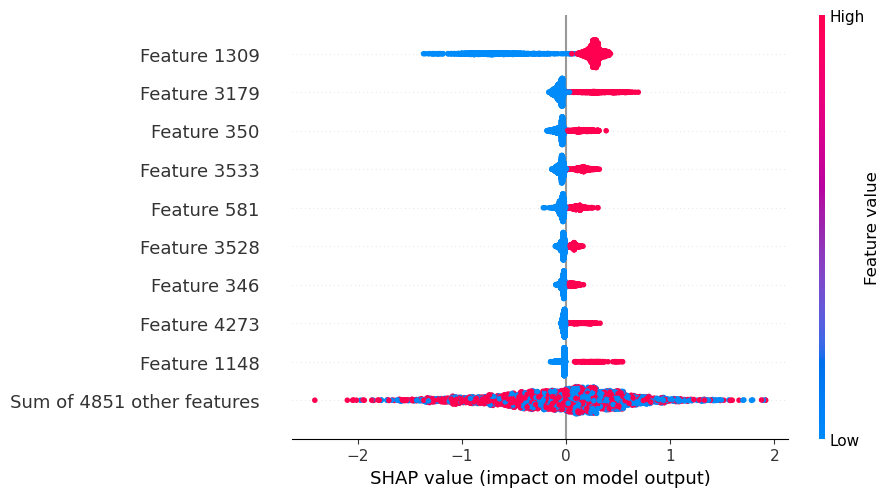

In [115]:
shap.plots.beeswarm(shap_values)

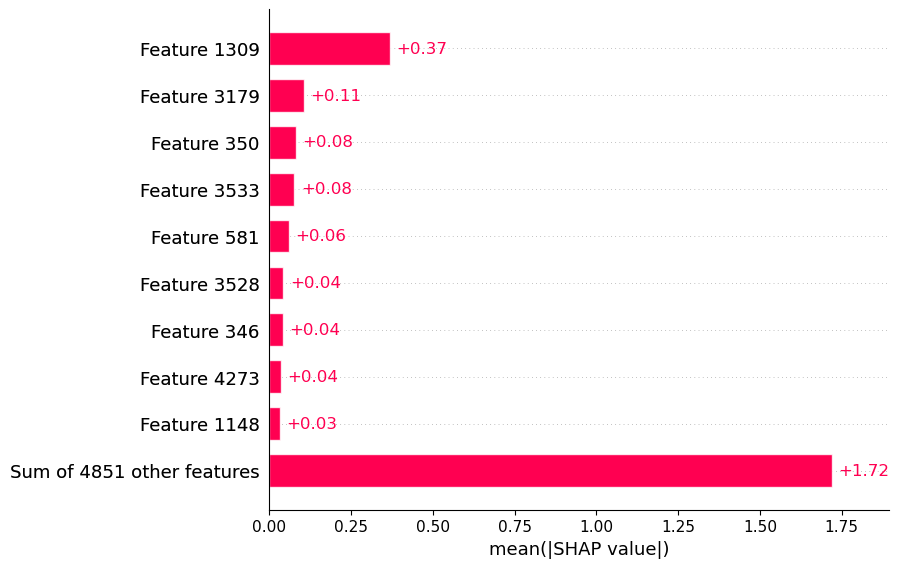

In [116]:
shap.plots.bar(shap_values)